In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import VOCSegmentation

In [2]:
# Define the U-Net model architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return self.conv_last(dec1)

In [3]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, base_dir, subset, transform=None):
        self.image_dir = os.path.join(base_dir, subset, 'image')
        self.mask_dir = os.path.join(base_dir, subset, 'mask')
        self.transform = transform
        self.images = os.listdir(self.image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Ensure mask is 3D tensor (height, width)
        # mask = mask.unsqueeze(0)
        return image, mask

In [4]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

base_dir = r"C:\Users\lewka\Downloads\archive\dl_folder"

# Create dataset objects
train_dataset = CustomDataset(base_dir=base_dir, subset="train", transform=transform)
val_dataset = CustomDataset(base_dir=base_dir, subset="val", transform=transform)
test_dataset = CustomDataset(base_dir=base_dir, subset="test", transform=transform)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Example usage: Iterate through the training data
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break

torch.Size([8, 3, 128, 128]) torch.Size([8, 1, 128, 128])


In [5]:
base_dir = r"C:\Users\lewka\Downloads\archive\dl_folder"
mask_dir = os.path.join(base_dir, 'train', 'mask')

# Initialize a set to store unique values
unique_values_set = set()

# Iterate through all mask images in the directory
for mask_filename in os.listdir(mask_dir):
    mask_path = os.path.join(mask_dir, mask_filename)
    mask = Image.open(mask_path).convert("L")
    mask_array = np.array(mask)
    
    # Update the set with unique values from the current mask
    unique_values_set.update(np.unique(mask_array))

# Convert the set to a sorted list
unique_values = sorted(unique_values_set)
print("Unique values in the masks:", unique_values)

# Determine the number of classes
num_classes = len(unique_values)
print("Number of classes:", num_classes)

Unique values in the masks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 2

Epoch [1/10], Train Loss: 0.5616, Val Loss: 0.8092
Epoch [2/10], Train Loss: 0.4305, Val Loss: 1.2578
Epoch [3/10], Train Loss: 0.3892, Val Loss: 0.6116
Epoch [4/10], Train Loss: 0.3497, Val Loss: 0.8884
Epoch [5/10], Train Loss: 0.3215, Val Loss: 0.3452
Epoch [6/10], Train Loss: 0.2981, Val Loss: 0.2886
Epoch [7/10], Train Loss: 0.2775, Val Loss: 0.2828
Epoch [8/10], Train Loss: 0.2660, Val Loss: 0.2526
Epoch [9/10], Train Loss: 0.2535, Val Loss: 0.2427
Epoch [10/10], Train Loss: 0.2419, Val Loss: 0.2342


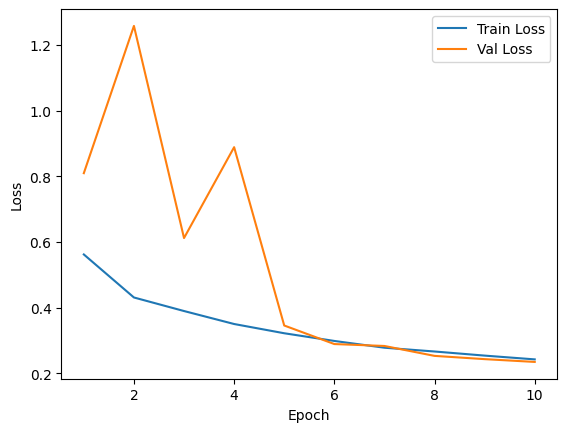

In [6]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses = []
val_losses = []
num_epochs= 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.float())  # Ensure masks are float tensors
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks.float())  # Ensure masks are float tensors
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
# Plot training and validation losses
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    
    return dice.mean().item()

def iou(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.mean().item()

def pixel_accuracy(pred, target):
    pred = pred.contiguous()
    target = target.contiguous()
    
    correct = (pred == target).float()
    accuracy = correct.sum() / correct.numel()
    
    return accuracy.item()

def mean_pixel_accuracy(pred, target):
    pred = pred.contiguous()
    target = target.contiguous()
    
    classes = target.unique()
    accuracies = []
    
    for cls in classes:
        cls_pred = pred == cls
        cls_target = target == cls
        correct = (cls_pred == cls_target).float()
        accuracy = correct.sum() / correct.numel()
        accuracies.append(accuracy.item())
    
    return np.mean(accuracies)

Dice Coefficient: 0.3086131513118744
IoU: 0.18318593502044678
Pixel Accuracy: 0.657440185546875
Mean Pixel Accuracy: 0.997323751449585


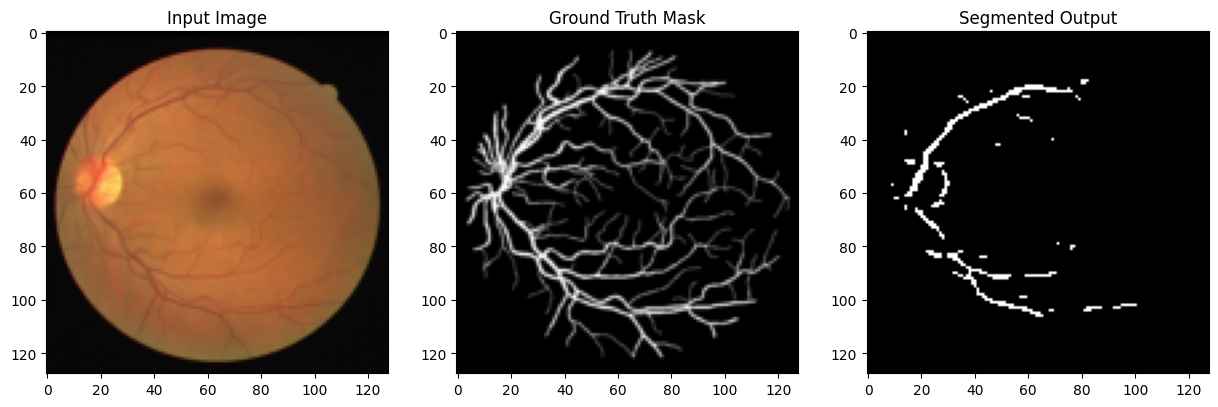

In [8]:
model.eval()  # Set the model to evaluation mode
dice_scores = []
iou_scores = []
pixel_accuracies = []
mean_pixel_accuracies = []

with torch.no_grad():  # Disable gradient calculation
    for images, masks in test_loader:
        # Move images and masks to the appropriate device
        images, masks = images.to(device), masks.to(device)
        
        # Perform model inference
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        outputs = (outputs > 0.5).float()
        
        # Calculate metrics
        dice_scores.append(dice_coefficient(outputs, masks))
        iou_scores.append(iou(outputs, masks))
        pixel_accuracies.append(pixel_accuracy(outputs, masks))
        mean_pixel_accuracies.append(mean_pixel_accuracy(outputs, masks))
        
        # Break after processing one batch
        break

# Print the metrics
print("Dice Coefficient:", np.mean(dice_scores))
print("IoU:", np.mean(iou_scores))
print("Pixel Accuracy:", np.mean(pixel_accuracies))
print("Mean Pixel Accuracy:", np.mean(mean_pixel_accuracies))

# Display the results
plt.figure(figsize=(15, 5))

# Display the input image
plt.subplot(1, 3, 1)
plt.imshow(images[0].cpu().permute(1, 2, 0))
plt.title("Input Image")

# Display the ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')  # Remove the channel dimension
plt.title("Ground Truth Mask")

# Display the segmented output
plt.subplot(1, 3, 3)
plt.imshow(outputs[0].cpu().numpy().squeeze(), cmap='gray')  # Remove the channel dimension
plt.title("Segmented Output")

plt.show()